In [1]:
import sys,argparse,os,pandas,numpy,copy
sys.path.append('/home/heyangle/Desktop/ScanCraft/ScanCraft')
from command.file_operations.GetDirectories import GetDirectories
from command.file_operations.GetSamples import GetSamples

In [2]:
folders=GetDirectories(path='./',keyword='out_',numbered=True)
# folders=GetDirectories(path='./test_classify',keyword='out_',numbered=True)

In [3]:
folders

['/home/heyangle/Desktop/rand_NTools/output/out_0109',
 '/home/heyangle/Desktop/rand_NTools/output/out_0110',
 '/home/heyangle/Desktop/rand_NTools/output/out_0111']

In [4]:
# get all spectrum files
sample_collect=[
    GetSamples( path=os.path.join( folder,'record' ), patterns=['inp','spectr','omega'] )
    for folder in folders
]

In [5]:
samples=sum(sample_collect,[])

In [6]:
samples[-1].__dict__

{'documents': {'inp': '/home/heyangle/Desktop/rand_NTools/output/out_0111/record/inp.dat.4561',
  'omega': '/home/heyangle/Desktop/rand_NTools/output/out_0111/record/omega.dat.4561',
  'spectr': '/home/heyangle/Desktop/rand_NTools/output/out_0111/record/spectr.dat.4561'}}

In [7]:
len(samples)

13718

In [8]:
# test S2P
# from command.NMSSMTools import ReadNMSSMToolsSpectr as readNT
# from command.data_transformer.SpectrumToPandas import SpectrumToPandas as S2P
# spec=readNT(samples[0].documents['spectr'])
# S2P(spec)

In [11]:
# get spectrums
from command.NMSSMTools import ReadNMSSMToolsSpectr as readNT
for sample in samples:
    sample.spectr=readNT(sample.documents['spectr'])

In [12]:
sample.spectr.ABUNDANCE

{1: 31.506, 3: 3.029e-26, 4: 0.050187, 6: 14.0, 7: 24.0}

In [13]:
# get spectrum DataFrame
from command.data_transformer.SpectrumToPandas import SpectrumToPandas as S2P
spectrums=S2P([sample.spectr for sample in samples])

width= {199}


In [14]:
# mass=spectrums[('spectrum','MASS')][['25','35','36']]
# mass.to_csv('mass.csv')

In [18]:
nothing=[print(i,name_tuple) for i,name_tuple in enumerate(spectrums.columns)]

0 ('spectrum', 'ABUNDANCE', '1', 'unknown')
1 ('spectrum', 'ABUNDANCE', '3', 'unknown')
2 ('spectrum', 'ABUNDANCE', '4', 'unknown')
3 ('spectrum', 'ABUNDANCE', '6', 'unknown')
4 ('spectrum', 'ABUNDANCE', '7', 'unknown')
5 ('spectrum', 'ANNIHILATION', '(5, -5)', 'unknown')
6 ('spectrum', 'ANNIHILATION', '(6, -6)', 'unknown')
7 ('spectrum', 'ANNIHILATION', '(22, 22)', 'unknown')
8 ('spectrum', 'ANNIHILATION', '(22, 23)', 'unknown')
9 ('spectrum', 'ANNIHILATION', '(23, 23)', 'unknown')
10 ('spectrum', 'ANNIHILATION', '(23, 25)', 'unknown')
11 ('spectrum', 'ANNIHILATION', '(24, -24)', 'unknown')
12 ('spectrum', 'ANNIHILATION', "'SigmaV'", 'unknown')
13 ('spectrum', 'EXTPAR', '1', 'M1')
14 ('spectrum', 'EXTPAR', '2', 'M2')
15 ('spectrum', 'EXTPAR', '3', 'M3')
16 ('spectrum', 'EXTPAR', '11', 'Atop')
17 ('spectrum', 'EXTPAR', '12', 'Abottom')
18 ('spectrum', 'EXTPAR', '13', 'Atau')
19 ('spectrum', 'EXTPAR', '16', 'Amuon')
20 ('spectrum', 'EXTPAR', '31', 'L1')
21 ('spectrum', 'EXTPAR', '32', '

In [8]:
# move spectrum files
# for i, s in enumerate(samples[30000:]):
#     new_documents={}
#     new_documents['inp']=os.path.join('./random_samples/record_4/','inp.dat.'+str(i))
#     new_documents['spectr']=new_documents['inp'].replace('inp','spectr')
#     new_documents['omega']=new_documents['inp'].replace('inp','omega')
#     s.MoveTo(new_documents)

In [9]:
#normalize=numpy.linalg.inv(numpy.diag([60,1e3,2e3,6e3,2e3,2e3,2e3,1,1,3e3,3e3,1500]))
# set input point mold
import sys,pandas
sys.path.append('/home/heyangle/Desktop/ScanCraft/ScanCraft')
from command.scan.scan import scan

mold=scan(method='random')
mold.AddScalar('tanB','MINPAR',3,1.,60.)
mold.AddScalar('Atop','EXTPAR'   ,11  ,  -6e3    ,6e3)
mold.AddFollower('Abottom','EXTPAR'   ,12,'Atop')
mold.AddScalar('Lambda','EXTPAR'  ,61  ,1e-3    ,1. ,prior_distribution='exponential')
mold.AddScalar('Kappa','EXTPAR'   ,62 ,1.e-3    ,1. ,prior_distribution='exponential')
mold.AddScalar('A_Lambda','EXTPAR' ,63,-3.e3,3.e3)
mold.AddScalar('A_kappa','EXTPAR' ,64,-3.e3,3.e3)
mold.AddScalar('mu_eff','EXTPAR'  ,65,100.,1500.)

In [10]:
mold.free_parameter_list.keys()

dict_keys(['tanB', 'Atop', 'Lambda', 'Kappa', 'A_Lambda', 'A_kappa', 'mu_eff'])

In [11]:
# get input points
for sample in samples:
    sample.input=copy.deepcopy(mold)
    in_file=sample.documents['inp']
    sample.input.GetValue(in_file)

In [12]:
# from command.data_transformer.InputListToPandas import InputListToPandas as I2P
# input_list=[point.input for point in samples]
# input_table=I2P(input_list,title='accepted')
# input_table[('flags','binary','1/0_is/not','calculable')]=1

In [10]:
samples[0].spectr.NDMCROSSSECT

{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0}

In [12]:
spectrums#['spectrum']#['NDMCROSSSECT']

0
1
2
3
4
5
6
7
8
9


In [9]:
sorted(samples[0].spectr.__dict__.keys())

['ABUNDANCE',
 'AD',
 'AE',
 'ANNIHILATION',
 'AU',
 'DCINFO',
 'DECAY',
 'DSQMIX',
 'EFFECTIVE_COUPLINGS',
 'ERROR',
 'EXTPAR',
 'FINETUNING',
 'GAUGE',
 'GUTAD',
 'GUTAE',
 'GUTAU',
 'GUTGAUGE',
 'GUTMSOFT',
 'GUTNMSSMRUN',
 'GUTYD',
 'GUTYE',
 'GUTYU',
 'HIGGSBOUNDSINPUTHIGGSCOUPLINGSBOSONS',
 'HIGGSBOUNDSINPUTHIGGSCOUPLINGSFERMIONS',
 'HMIX',
 'LHCCROSSSECTIONS',
 'LHCFIT',
 'LOWEN',
 'LSP',
 'MASS',
 'MINPAR',
 'MODSEL',
 'MSD2',
 'MSE2',
 'MSL2',
 'MSOFT',
 'MSQ2',
 'MSU2',
 'NDMCROSSSECT',
 'NMAMIX',
 'NMHMIX',
 'NMNMIX',
 'NMSSMRUN',
 'RDINFO',
 'REDCOUP',
 'SBOTMIX',
 'SELMIX',
 'SMINPUTS',
 'SPINFO',
 'STAUMIX',
 'STOPMIX',
 'TD',
 'TE',
 'TU',
 'UMIX',
 'USQMIX',
 'VMIX',
 'YD',
 'YE',
 'YU',
 'constraints']

In [17]:
sample.spectr.ANNIHILATION

{(0, 0): 2.0908e-30, (22, 22): 0.089602, (22, 23): 0.9104}

In [36]:
from command.format.block_table import block_table
Mh_list=[]
for mass in [i.spectr.MASS for i in samples]:
    Mh_list.append([mass[25],mass[35],mass[45]])
Mh_array=numpy.array(Mh_list)
Mh_column=pandas.MultiIndex.from_tuples(
    [tuple(['spectr','MASS',i,block_table.MASS(i)]) for i in [25,35,45]]
    ,names=['title','block','code','name']
)
Mh=pandas.DataFrame(Mh_array,columns=Mh_column)

In [49]:
# Mh.to_csv('Higgs_mass.csv')

In [34]:
DM_list=[]
for sample in samples:
    spec=sample.spectr
    if any([i in spec.constraints for i in ['# Lightest neutralino is not the LSP','# Problem in micrOMEGAs']]):
        DM_list.append([numpy.nan]*6)
    else:
        DM_list.append([
            spec.ABUNDANCE[4],spec.NDMCROSSSECT[1],spec.NDMCROSSSECT[2],spec.NDMCROSSSECT[3],spec.NDMCROSSSECT[4],
            spec.ANNIHILATION[(0, 0)]
        ])
DM_array=numpy.array(DM_list)
DM_column=pandas.MultiIndex.from_tuples(
    [('DM','ABUNDANCE','4','relic_density')]+
    [
        tuple(['DM','NDMCROSSSECT',i,'direct_search']) for i in [1,2,3,4]
    ]+
    [('DM','ANNIHILATION',0,'sigmaV')]
)
DM=pandas.DataFrame(DM_array,columns=DM_column)

In [38]:
Bph_list=[]
for sample in samples:
    low=sample.spectr.LOWEN
    Bph_list.append(
        [
            low[1],low[4]
        ]
    )
Bph_array=numpy.array(Bph_list)
Bph_column=pandas.MultiIndex.from_tuples(
    [
        ('Bphysics','LOWEN',1,'b_sg'),
        ('Bphysics','LOWEN',4,'b_mumu')
    ]
)
Bph=pandas.DataFrame(Bph_array,columns=Bph_column)

In [8]:
# collect csv files in different files into one.
import pandas
accl=[]
excl=[]
for directory in folders:
    accl.append(pandas.read_csv(os.path.join(directory,'accepted.csv'),header=[0,1,2,3],index_col=0))
    excl.append(pandas.read_csv(os.path.join(directory,'excluded.csv'),header=[0,1,2,3],index_col=0))
    
# acc1=pandas.read_csv('out_0103/accepted.csv',header=[0,1,2,3],index_col=0)
# acc2=pandas.read_csv('out_0104/accepted.csv',header=[0,1,2,3],index_col=0)
# exc1=pandas.read_csv('out_0103/excluded.csv',header=[0,1,2,3],index_col=0)
# exc2=pandas.read_csv('out_0104/excluded.csv',header=[0,1,2,3],index_col=0)

In [9]:
acc=accl[0].append(accl[1:],ignore_index=True)
exc=excl[0].append(excl[1:],ignore_index=True)
print(acc.shape,exc.shape)

(13718, 8) (586282, 8)


In [10]:
acc.to_csv('accepted_train.csv')
exc.to_csv('excluded_train.csv')

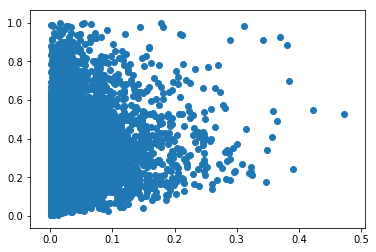

In [30]:
import matplotlib.pyplot as plt
plt.figure()
plt.scatter(acc.iloc[:,2],acc.iloc[:,3])
plt.show()

In [11]:
acc

title   accepted                                                             \
block     MINPAR       EXTPAR                                                 
code           3           11        61        62           63           64   
name        tanB         Atop    Lambda     Kappa     A_Lambda      A_kappa   
0      34.506321  -443.580442  0.172665  0.429379  2078.206358  -462.530822   
1      40.560985  1792.033575  0.032153  0.504402  2315.582739 -2535.047835   
2      27.897304  2822.441566  0.014072  0.775882  -940.976540 -2190.337243   
3      27.783309 -4107.418783  0.001191  0.167846   102.349379  -830.807631   
4      52.185931   987.663844  0.012050  0.182961  -806.189045 -1821.639332   
5      55.983706  1982.988082  0.005862  0.303273 -1694.641439 -2064.128728   
6      20.724820  1260.786731  0.007455  0.238409   579.376443 -1295.961193   
7      56.328524  -663.627915  0.186703  0.108784  2899.356400 -1735.744340   
8      59.366297  -931.027071  0.007649  0.050949  1150.153811 -2424.283201   
9      41.209526   833.107539  0.045172  0.227667  1325.125767  -612.796181   
10     30.829111   991.662299  0.009903  0.090639   186.346290 -1120.583305   
11     37.507078  1454.735690  0.008932  0.113171   468.612777 -1265.600624   
12     32.271775   527.682888  0.007402  0.157578   731.044369 -1520.823089   
13     50.698242  -299.313501  0.024895  0.131087 -1636.387562 -1629.650626   
14     58.136139   197.310916  0.007215  0.247319  1944.050868 -1753.264415   
15     54.615899 -2296.861061  0.095843  0.190610  2104.622962 -1658.728592   
16     40.285424  4877.246816  0.009474  0.562114  1022.273729 -2124.187450   
17     23.631977   775.764457  0.013297  0.341171  -352.466030  -451.682265   
18     33.603780  2487.509078  0.008488  0.473797 -2119.601070 -2362.940180   
19     56.665292  1822.975142  0.003007  0.328905   -69.004570 -1323.323529   
20     55.490946 -3938.311231  0.023725  0.335194  1008.901685  -165.480911   
21     44.815188  2021.630182  0.009612  0.111167  1352.359323 -1762.480058   
22     38.276371 -3662.984374  0.026429  0.397410  2507.326572  -291.016100   
23     45.737550 -3015.554939  0.023383  0.081799  2230.095896  -472.603420   
24     54.610851  1899.087357  0.053709  0.328239  1168.606950  -679.464766   
25     34.007129 -1949.098668  0.018801  0.081052  2420.077195  -184.355678   
26     38.078434  -481.876269  0.048888  0.230527  -122.779212  -545.470019   
27     50.010252  2655.392682  0.002194  0.130392  1221.909159  -639.738904   
28     38.253094  3935.097853  0.001977  0.068945  1832.599294 -2853.594234   
29     55.531580  1524.780462  0.077124  0.111542  2375.766558  -576.890156   
...          ...          ...       ...       ...          ...          ...   
6602   58.303374 -2077.739184  0.004583  0.162464  1233.457913 -1666.080616   
6603   53.631072    92.096983  0.030297  0.103718  2523.526768 -1497.534394   
6604   49.684239 -1044.320166  0.063105  0.477936   595.481171 -2845.896552   
6605   38.545248 -2233.983141  0.006777  0.094475  2680.337623 -2287.330532   
6606   59.850906 -1050.750281  0.017090  0.144216   164.359117  -852.930277   
6607   33.911133 -1342.421471  0.020941  0.258643  2653.761641 -1480.279120   
6608   59.175417   -20.169589  0.007789  0.266966 -2689.918584 -1275.671260   
6609   48.829771 -4748.447504  0.082006  0.365773  1692.263655  -811.701527   
6610   26.400224  -830.452068  0.059107  0.595931  2093.653464  -440.222977   
6611   38.973023 -2765.707633  0.044446  0.524150  1944.725405 -2184.605750   
6612   43.162306 -4576.709004  0.016750  0.310192  2100.232166 -1805.344958   
6613   33.333109  1990.498934  0.005262  0.493980  -615.446020 -2494.874542   
6614   55.557014  -766.809439  0.139794  0.201039  2485.672589 -2328.016029   
6615   52.317417 -3303.933760  0.050323  0.432555  2779.507210  -801.262566   
6616   30.997633 -1473.170995  0.055231  0.475019 -2511.960477  -527.583368   
6617   55.119071  2705.674859  0.004899  0.125671 